# Harris Corner Detector.
In this lab the Harris Corner Detector is implemented from the method discussed in the lessons.

> Corners are detected in local image regions using the corner reponse function $R=Det(M)-\alpha Trace(M)^2$ which is formed from the Determinate and Trace of the matrix $ M = \begin{vmatrix} A & C \\ C & B \end{vmatrix}$. M is referred to as the second moment matrix (slide 11).

> The second moment matrix nominally consists of the 2nd order partial derivatives of change in intensity of the image e.g. $A = \frac{\partial^2{E_{0,0}}}{\partial{x}^2}$.

> The 2nd order partial derivatives can be approximated from products of partial derivatives of the image convolved with a small gaussian window $\frac{\partial^2{E_{0,0}}}{\partial{x}^2} = \sum_{u,v} 2 w_{u,v} (\frac{\partial{I_{u,v}}}{\partial{x}}\frac{\partial{I_{u,v}}}{\partial{x}} )= X^2\circledast W$ . (slide 9)

> The first order image derivatives can be obtained using any finite difference approximate to the derivative or with by filtering the image with the x and y sobel kernels $\frac{\partial{I_{u,v}}}{\partial{x}}= X=I_{u,v}\circledast x_{sobel}$ (slide 7)






**HouseKeeping:** Load test image, import required packages (you can swap between the checkerboard test image, which is very useful to determine that the algorithm works properly and other images from the web to try out)

In [127]:
import numpy as np
from scipy import signal
import cv2
import matplotlib.pyplot as plt
import urllib.request
import os
from urllib.parse import urlparse

In [128]:
# function to read images from Web addresses.
def download_image(url, save_path):
    """
    Downloads an image from a URL and saves it to disk.
    If the image already exists at the specified path, it is read from disk.

    Args:
        url (str): URL of the image.
        save_path (str): Path to save the image on disk.

    Returns:
        None
    """
    # Parse the URL to get the filename
    filename = os.path.basename(urlparse(url).path)
    image_path = os.path.join(save_path, filename)

    # Check if the image already exists
    if os.path.exists(image_path):
        print(f"Image already exists at {image_path}. Reading from disk.")
        image = cv2.imread(image_path)
    else:
        print(f"Downloading image from {url}...")
        resp = urllib.request.urlopen(url)
        temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
        temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
        temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
        print(f"Image downloaded and saved at {image_path}.")
        cv2.imwrite(image_path, temp_image)
        image = cv2.imread(image_path)
    return image

# Function to normalise images for display
def norm_img(ip_img):
   norm_img = ip_img-np.min(ip_img)
   norm_img = norm_img/(np.max(ip_img)-np.min(ip_img))
   return norm_img

Image already exists at ./800px-10x10_checkered_board.svg.png. Reading from disk.


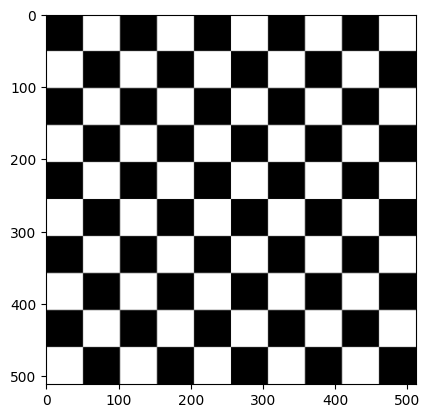

In [129]:
# Import and resize corner regions.
# read in test image
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/10x10_checkered_board.svg/800px-10x10_checkered_board.svg.png"
image = download_image(image_url,save_path="./")

# Rescale & Crop Image
HW_trg =512
img_H = np.shape(image)[0]
img_W = np.shape(image)[1]
min_dim_size = min(img_H,img_W)
scale_fac = HW_trg/min_dim_size
scale_img_H = int(np.ceil(np.shape(image)[0]*scale_fac))
scale_img_W = int(np.ceil(np.shape(image)[1]*scale_fac))
rescale_image = cv2.resize(image, (scale_img_W,scale_img_H), interpolation = cv2.INTER_AREA)
crop_image = rescale_image[0:HW_trg, 0:HW_trg]
input_image = cv2.cvtColor(crop_image, cv2.COLOR_BGR2GRAY)
plt.imshow(input_image,'gray')

#Harris Algorithm (part 1)
In order to be able to form the components of the matrix M we will carry out the following steps:

1.   Complete the function `grad_kernel` to output the gradient (sobel) kernel. Also complete the function `gauss_kernel` to output the Gaussian kernel. (Note all kernels are 2d)
2.   Complete the function `est_part_derv` to determine estimates of 1st order partial derivatives of the image $(\frac{\partial{I_{u,v}}}{\partial{x}},\frac{\partial{I_{u,v}}}{\partial{y}})$ by convolving the image with the gradient (sobel or prewitt) kernels.
3.   Complete the function `prod_part_derv` that will obtain the products of 1st order partial derivatives (e.g. $XY= \frac{\partial{I_{u,v}}}{\partial{x}} \frac{\partial{I_{u,v}}}{\partial{y}}$).
4.  Complete the function `conv_prod` that will convolve the products of 1st order partial derivatives with the guassian kernel to obtain components of the second moment matrix $M = \begin{pmatrix}
A & C \\
C & B
\end{pmatrix}$ (e.g. $ A = X^2 \circledast W$).

Hints:
 * It is best to consistently use numpy methods (arrays) to complete this lab.
 * In order to define the [sobel](https://en.wikipedia.org/wiki/Sobel_operator) kernel, the [numpy array method](https://numpy.org/doc/stable/reference/generated/numpy.array.html) can be used (A 2D array will be required).
 * The gaussian kernel can be defined in exactly the same way as seen in a previous lab (i.e. creating a 1D array over a range of pixels and using outer product to create a 2D array)
 * In order to perform 2D convolution between the image (or other array) and the kernels, the [scipy convolve 2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html) method can be used.

In [130]:
# 1a. Complete functions to output gradient and gaussian kernels

def grad_kernel(kernel_type='sobel'):
   '''
     Outputs:
      kernelx: 2d numpy array, x-direction kernel (filters vertical edges)
      kernely: 2d numpy array, y-direction kernel (filters horizontal edges)
   '''
   #### Your Code Here ####
   if kernel_type == 'sobel':
    kernelx = np.array([[-1, 0, 1],
                       [-2, 0, 2],
                       [-1, 0, 1]])

    kernely = np.array([[-1, -2, -1],
                       [ 0,  0,  0],
                       [ 1,  2,  1]])
   elif kernel_type == 'prewitt':
    kernelx = np.array([[-1, 0, 1],
                       [-2, 0, 2],
                       [-1, 0, 1]])

    kernely = np.array([[-1, -2, -1],
                       [ 0,  0,  0],
                       [ 1,  2,  1]])

   return [kernelx,kernely]

def gauss_kernel(sigma):
    '''
      Inputs:
        sigma: Parameter controlling Gaussian blur (and size of kernel)
      Outputs:
        gauss_2d_kernel: 2d numpy array
    '''
    #### Your Code Here ######
    M = int(6 * sigma + 1)
    x = np.arange(-M / 2 , M / 2+1)
    xx, yy = np.meshgrid(x, x)
    gauss_2d_kernel = np.exp(-(np.square(xx) + np.square(yy)) / (2 * np.square(sigma)))

    # Normalize the kernel so that the sum of all elements equals 1
    gauss_2d_kernel /= np.sum(gauss_2d_kernel)
    return gauss_2d_kernel


Gradient Kernels  [[-1  0  1]
 [-2  0  2]
 [-1  0  1]] [[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]


Text(0.5, 1.0, 'Gaussian kernel')

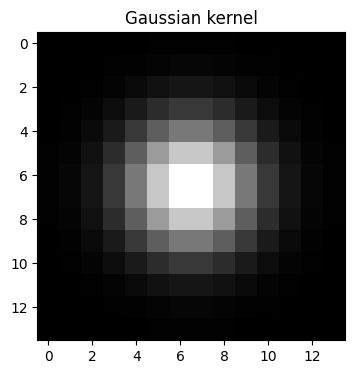

In [131]:
# 1b. Run functions and generate gradient and gaussian kernels
grad_kernels = grad_kernel()
print('Gradient Kernels ',grad_kernels[0],grad_kernels[1])

sigma =2
gauss_2d_kernel = gauss_kernel(sigma)
# Plot gaussian kernel
fig = plt.figure(figsize=(4,4))
plt.imshow(gauss_2d_kernel,'gray')
plt.title('Gaussian kernel')

In [132]:
# 2a. Obtain estimates of 1st order parital derivatives of the image by convolution with sobel (or prewitt) kernels
def est_part_derv(grad_kernels,input_image):
   '''
     Inputs:
        grad_kernels: tuple of x and y direction kernels [kernelx,kernely] (numpy arrays)
        input image: gray scale input image (2d numpy array)
     Outputs:
        derv_x: estimate of partial derivative x direction (2d numpy array)
        derv_x: estimate of partial derivative x direction (2d numpy array)
   '''
   #### Your Code Here ####
   kernelx, kernely = grad_kernels

   derv_x = signal.convolve2d(input_image, kernelx, mode='same', boundary='symm')
   derv_y = signal.convolve2d(input_image, kernely, mode='same', boundary='symm')

   return [derv_x,derv_y]

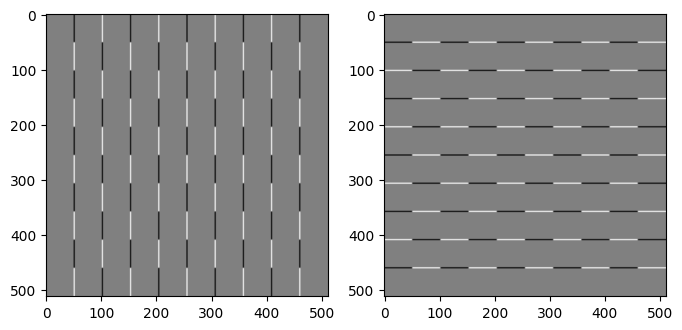

In [133]:
# 2b. Obtain estimates of partial derivatives
part_derv = est_part_derv(grad_kernels,input_image)

# Plot Images showing partial derivatives
fig = plt.figure(figsize=(8,8))
def plot_filter(A,i):
   ax = fig.add_subplot(1,2, i)
   ax.imshow(A,'gray')
plot_filter(norm_img(part_derv[0]),1)
plot_filter(norm_img(part_derv[1]),2)

In [134]:
# 3a. Complete function to obtain products of 1st order partial derivatives.
def prod_part_derv(part_derv):
    '''
      Inputs:
        part_derv: tuple partial derivative [derv_x,derv_y] (numpy arrays)
      Outputs:
        Xsq: product of x direction partial derivative with itself (2d numpy array)
        Ysq: product of y direction partial derivative with itself (2d numpy array)
        XY: product of x direction partial derivative with y direction partial derivative
    '''
    #### Your Code Here ####
    derv_x, derv_y = part_derv

    Xsq = derv_x * derv_x
    Ysq = derv_y * derv_y
    XY = derv_x * derv_y

    return [Xsq,Ysq,XY]

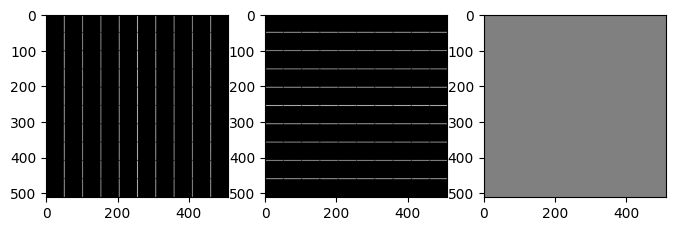

In [135]:
#3b. Obtain Products of 1st order partial derivatives.
prod_vals = prod_part_derv(part_derv)

# Plot products
fig = plt.figure(figsize=(8,8))
def plot_filter(A,i):
   ax = fig.add_subplot(1,3, i)
   ax.imshow(A,'gray')
plot_filter(norm_img(prod_vals[0]),1)
plot_filter(norm_img(prod_vals[1]),2)
plot_filter(norm_img(prod_vals[2]),3)

In [136]:
# 4a. Complete function to Convolve products with Gaussian
def conv_prod(prod_part_derv,gauss_2d_kernel):
    '''
      Inputs:
        prod_part_derv: tuple products partial derivatives [Xaq,Ysq,XY] (2d numpy arrays)
        gauss_2d_kernel: Gaussian kernel with small sigma (numpy array)
      Outputs:
        A: Convolution of Xsq with gaussian kernel (2d numpy array)
        B: Convolution of Ysq with gaussian kernel (2d numpy array)
        C: Convolution of XY with gaussian kernel (2d numpy array)
    '''
    #### Your Code Here ####
    Xsq, Ysq, XY = prod_part_derv

    A = signal.convolve2d(Xsq, gauss_2d_kernel, mode='same', boundary='symm')
    B = signal.convolve2d(Ysq, gauss_2d_kernel, mode='same', boundary='symm')
    C = signal.convolve2d(XY,  gauss_2d_kernel, mode='same', boundary='symm')

    return [A,B,C]

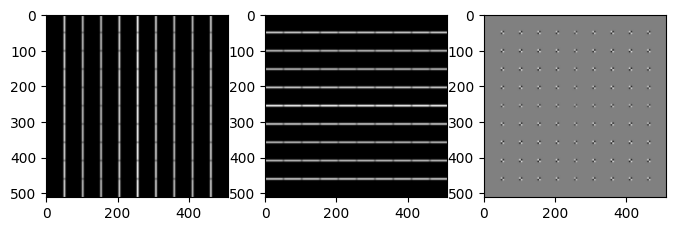

In [137]:
#4b. Convolve products with gaussian
[A,B,C] = conv_prod(prod_vals,gauss_2d_kernel)

# Plot Components
fig = plt.figure(figsize=(8,8))
def plot_filter(A,i):
   ax = fig.add_subplot(1,3, i)
   ax.imshow(A,'gray')
plot_filter(norm_img(A),1)
plot_filter(norm_img(B),2)
plot_filter(norm_img(C),3)

#Harris Algorithm (part2)

1. Complete the Corner Response Function `response_function`. The corner response function is determined as the difference (with a scaling factor $\alpha$ between the Determinant and trace of the matrix M $(R=Det(M)-\alpha Trace(M)^2)$. As shown in the slides, the Determinat and Trace can be easily found from the elements of the matix $M$.
> $Det(M) = AB-C^2$

>> $Trace(M) = A+B$

2. Display the coner response function with the given code snippet. Ensure that the corner response function makes sense, do the maxima and minima appear where you expect them?

3. Complete the function `det_coords` to determine the coordinates of the local maxima of the response function.
 * The x,y coordinates of local maxima in the image are obtained using the peak_local_max method as shown in the [scikit learn example](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_peak_local_max.html).
  * However If we apply peal_local_max directly on the response function we will obtain a large number of maxima corresponding to small variations in the flat regions. Not just the corner regions.
  * Therefore we can use a threshold value (given as an input to the det_coords function) and find where the pixel values are greater than the thresold. Using a greater or less than operation (between threshold and image) produces a binary value at each pixel. We then need to multiply this binary result by the original response function and we will be left with only the peaks of the response function.

4. Mark corners on the original image with the given code snippet. (Note you will need to reload the image (3rd cell above) if you want to remove dots that have already been added by earlier attempts det_coords function)

In [138]:
# 1. Obtain Corner response Function
alpha = 0.04

def response_fun(mom_mat_comp):
   '''
    Inputs:
      mom_mat_comp: Tuple containing components 2nd moment matrix (A,B,C) each 2d numpy array
    Ouptuts:
      op_response: Output of response function 2d numpy array
   '''
   ###  Your Code Here #####
   A, B, C = mom_mat_comp
   det_M = A * B - (C * C)
   trace_M = A + B

   op_response = det_M - alpha * np.square(trace_M)
   return op_response

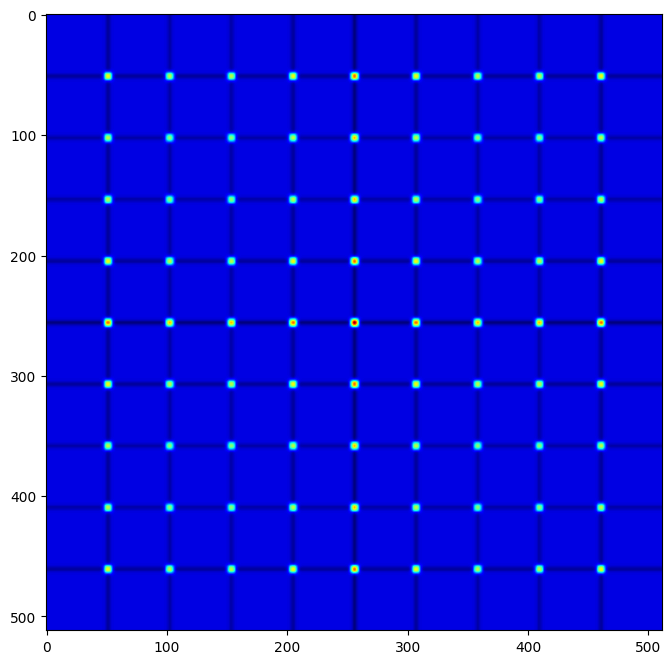

In [139]:
# 2. Plot Corner response function
op_response = response_fun([A,B,C])

fig = plt.figure(figsize=(8,8))
plt.imshow(norm_img(op_response),'jet')

In [140]:
# 3. Complete function to detect coordinates
from skimage.feature import peak_local_max

def det_coords(op_response,threshold_val = 80):
   '''
     Inputs:
        op_resonse: 2d numpy array
        threshold_val: scalar value
     Outputs:
        coords: list of coordinate x,y tuples
        thresh_response: op_response after thresholding operation (2d numpy array)
   '''

   ##### Your Code here #####
   thresh_response = (op_response > threshold_val) * op_response

   coordinates =  peak_local_max(thresh_response, threshold_abs=threshold_val , min_distance=20)

   return coordinates,thresh_response



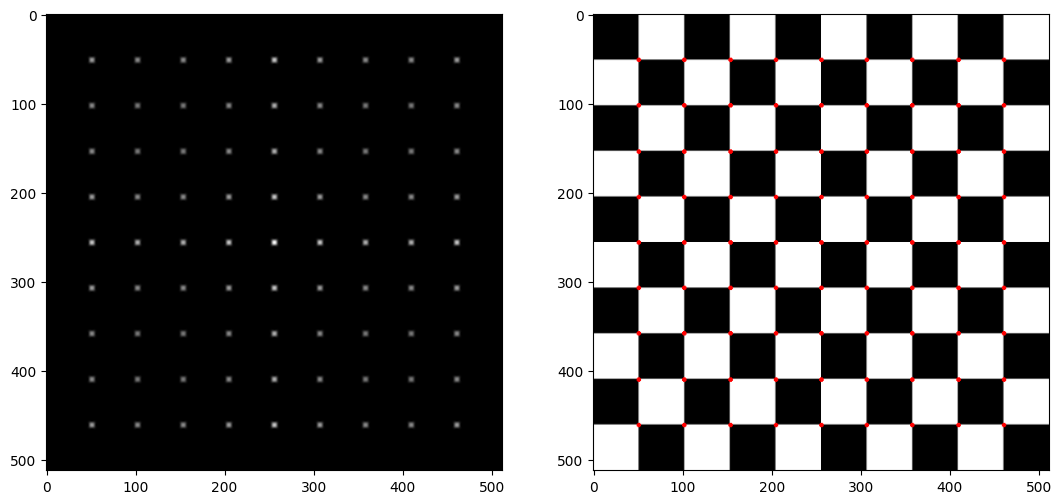

In [141]:
# .4 Call function and plot coordinates on original image

# Call function
coordinates,thresh_response = det_coords(op_response,threshold_val = 80)

# Mark coordinates on image
for xy_pos in coordinates:
   cv2.circle(crop_image, (xy_pos[1],xy_pos[0]), 1, (255,0,0),thickness=2)

# Plot image.
fig = plt.figure(figsize=(20,10))
def plot_filter(A,i):
   ax = fig.add_subplot(1,3, i)
   ax.imshow(A,'gray')
plot_filter(norm_img(thresh_response),1)
plot_filter(crop_image,2)
